# Covid in Scotland Visualisations

Is population density a good predictor of coronavirus infections in Scotland? If not, can I find something that is?

At the very least, I'd like to draw some comparisons that I haven't seen talked about.

Import libraries to use

In [1]:
import geopandas as gpd
import pandas as pd
from matplotlib import pyplot as plt
import json
from shapely.geometry import Polygon, LinearRing, shape
from shapely.ops import cascaded_union
import matplotlib as mpl
import seaborn as sns
import numpy as np

In [2]:
LAShape = gpd.read_file("data/LAAreas.shp")

covidByLA = pd.read_csv("data/total_cases_by_la_20210113.csv")

#print(LAShape.head())
#print(covidByLA.head())

Inspect the data, make sure it looks right.
LA Shape should be a council number and multipolygon;
covidByLA is a date, council number and name, then mortality statistics.

In [3]:
#print(LAShape.head(2))

#print(covidByLA.head(2))

In the shape file loaded above, each council has a unique 8 digit code with a leading S: a CA number. There are 32 local authority areas, and we can generally map the first two digits of the postcode to the LA. As seen above, the covid deaths by local authority also have CA numbers.

Left join the spatial data with the death data:

In [4]:
#print(LAShape.head(2))
allData = LAShape.merge(covidByLA.rename({'CA': 'Council_r'}, axis=1),
               left_on='LAN', right_on='Council_r', how='left').drop('Council_r', axis = 1)
#print(allData.head(2))

In [5]:
areaPopn = pd.read_csv("data/councilAreaPopn.txt", delimiter = "  ", engine='python').drop(["Ind", "Electors"], axis = 1)
areaPopn = areaPopn.sort_values(by="CAName").reset_index().rename({'CAName': 'CAName_r'}, axis=1)
areaPopn = areaPopn.drop("index", axis = 1)
#print(areaPopn.head(5))

In [21]:
popn = areaPopn.Population
density = areaPopn.Density
area = areaPopn.Area

# add the population and density columns to the larger dataframe
allData["Population"] = popn
allData["Density"] = density
allData["Area"] = area

print(allData.head(5))

allData["TotalCasesNornPopn"] = allData["TotalCases"]/allData["Population"]

         LAN                                           geometry      Date  \
0  S12000033  MULTIPOLYGON (((382317.275 798730.809, 382302....  20210113   
1  S12000034  MULTIPOLYGON (((375338.002 764464.197, 375299....  20210113   
2  S12000041  MULTIPOLYGON (((332300.432 731128.778, 332286....  20210113   
3  S12000020  MULTIPOLYGON (((318734.660 810885.610, 318687....  20210113   
4  S12000017  MULTIPOLYGON (((172564.499 740754.001, 172574....  20210113   

          CAName  NewPositive  TotalCases  CrudeRatePositive  NewDeaths  \
0  Aberdeen City           65        5299        2317.313159          3   
1  Aberdeenshire           80        4187        1602.924850          2   
2          Angus           29        2103        1809.810671          1   
3          Moray           12         673         702.358589          0   
4       Highland           49        2116         897.256498          1   

   TotalDeaths  CrudeRateDeaths  TotalNegative  CrudeRateNegative  Population  \
0    

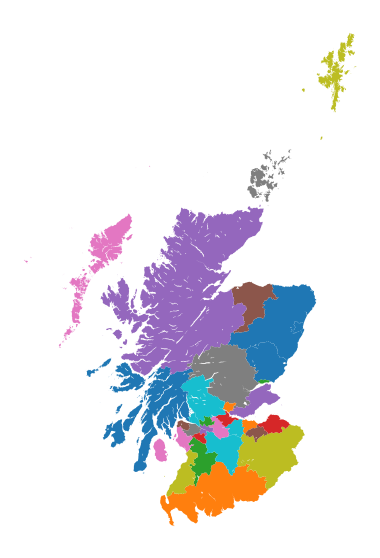

In [23]:
fig = plt.figure(figsize=(10,10))
ax1 = fig.add_subplot(111)
ax1 = allData.plot(column = "CAName", ax = ax1)
ax1.set_axis_off()
plt.show()
fig.savefig("LocalAuths.png", dpi=300)

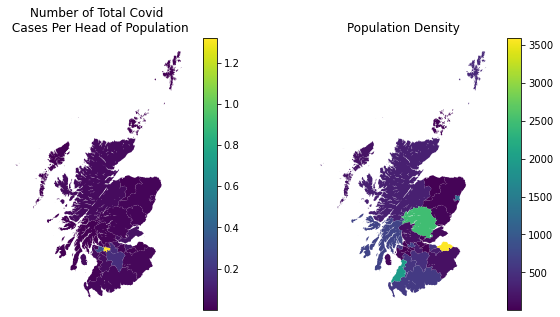

In [24]:
fig = plt.figure(figsize=(10,5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
ax1 = allData.plot(column = "TotalCasesNornPopn", ax = ax1, legend=True)
ax1.set_axis_off()
ax1.title.set_text("Number of Total Covid \n Cases Per Head of Population")
ax2.title.set_text("Population Density")
ax2 = allData.plot(column = "Density", ax = ax2, legend=True)
ax2.set_axis_off()
plt.show()
fig.savefig("totalcasesvsdensity.png", dpi=300)

The left figure shows the number of new cases per day divided by the number of people in the given area. If population density is a very good predictor of case denisity, we'd expect a fairly uniformly purple map.

We can see that cities are more densely populated than the rest of the country. By seperating the cities from the rural areas, can we plot population denisity in rural areas relative to other rural areas?

In the left figure, Glasgow is pretty obviously an outlier. If we remove Glasgow from the figure, how does the rest of Scotland look relative to itself?

In [ ]:
fig = plt.figure(figsize=(10,5))
ax1 = fig.add_subplot(111)
ax1 = allData.plot(column = "TotalCasesNornPopn", ax = ax1, legend=True)
ax1.set_axis_off()
ax1.title.set_text("Number of Total Covid \n Cases Per Head of Population")


ax2 = fig.add_subplot(122)
ax2 = woGla.plot(column = "TotalCasesNornPopn", ax = ax2, legend=True)
ax2.title.set_text("Without Glasgow")
ax2.set_axis_off()
plt.show()
fig.savefig("rmGla.png", dpi=300)

/Users/jaymackenzie/opt/miniconda3/lib/python3.8/site-packages/geopandas/geodataframe.py:853: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


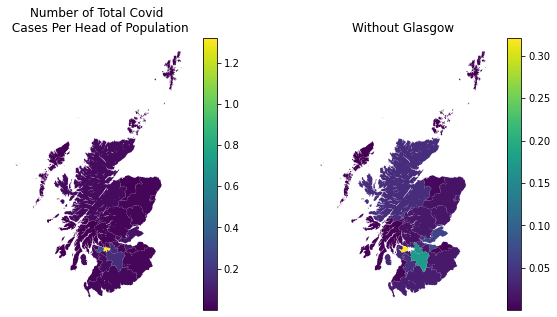

In [16]:
allData[allData["CAName"] == "Glasgow City"].TotalCasesNornPopn = 0.0
woGla = allData.drop(22, axis =0)

fig = plt.figure(figsize=(10,5))
ax1 = fig.add_subplot(121)
ax1 = allData.plot(column = "TotalCasesNornPopn", ax = ax1, legend=True)
ax1.set_axis_off()
ax1.title.set_text("Number of Total Covid \n Cases Per Head of Population")


ax2 = fig.add_subplot(122)
ax2 = woGla.plot(column = "TotalCasesNornPopn", ax = ax2, legend=True)
ax2.title.set_text("Without Glasgow")
ax2.set_axis_off()
plt.show()
fig.savefig("rmGla.png", dpi=300)

In [10]:
# want something like:
# if density > 500, add to urban
# else add to rural
# data with greater

In [17]:
# load simd spatial and socio-economic data
SIMDspatial = gpd.read_file("data/sc_dz_11.shp").drop(["Name", "TotPop2011", "StdAreaHa", "Shape_Leng"], axis = 1)
SIMDcsv = pd.read_csv("data/simd2020_withinds.csv")

# rename column to left join
SIMDspatial = SIMDspatial.rename({'DataZone': 'Data_Zone_r'}, axis=1)

In [12]:
# left join on zone number and remove extraneous columns
SIMDmerged = SIMDcsv.merge(SIMDspatial,left_on='Data_Zone', right_on='Data_Zone_r', how='left')\
.drop(['Data_Zone_r', "SIMD2020v2_Rank", \
    "SIMD2020v2_Vigintile", "SIMD_2020v2_Percentile", "SIMD2020v2_Quintile"], axis = 1)

# plotting from SIMD isn't working, so add column to plot from to spatial data dataframe
Access_Domain_Rank = SIMDmerged["SIMD2020_Access_Domain_Rank"]
SIMDspatial["Access_Domain_Rank"] = Access_Domain_Rank

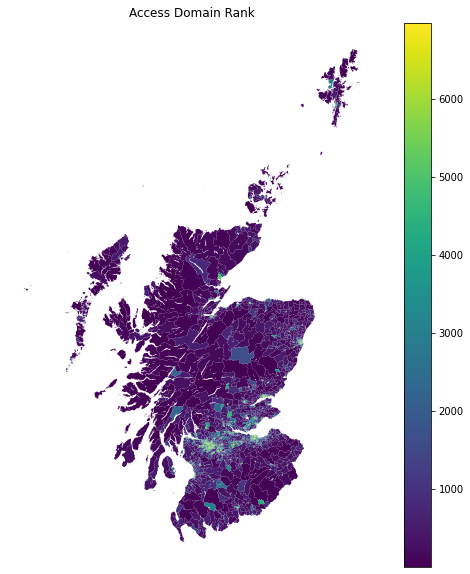

In [20]:
fig = plt.figure(figsize=(10,10))
ax1 = fig.add_subplot(111)
ax1 = SIMDspatial.plot(column = Access_Domain_Rank, ax = ax1, legend=True)
ax1.set_axis_off()
ax1.title.set_text("Access Domain Rank")

plt.show()
fig.savefig("SIMD.png", dpi=300)

[The Government also publishes the 7 day trend by neighbourhood](https://www.opendata.nhs.scot/dataset/covid-19-in-scotland/resource/8906de12-f413-4b3f-95a0-11ed15e61773). The data linked is visualised below.